# Dùng CycleGAN để chuyển ảnh qua lại giữa 2 domains

## 🏗️ Kiến trúc tổng thể

Gồm 2 thành phần:

1. **Generator (G)**: Học để **chuyển ảnh đầu vào thành ảnh đầu ra mong muốn**
2. **Discriminator (D)**: Phân biệt ảnh thật $y$ và ảnh sinh ra $G(x)$

---

## 🧠 1. Generator – **U-Net**

Generator trong Pix2Pix có kiến trúc **U-Net**, gồm:

* **Encoder**: chuỗi các convolution để trích xuất đặc trưng, giảm dần kích thước (downsampling)
* **Decoder**: chuỗi các transpose conv (up-conv) để khôi phục kích thước ảnh
* **Skip connection** giữa encoder và decoder ở cùng cấp

### 🎯 Mục đích:

* Encoder học thông tin trừu tượng
* Decoder tái tạo ảnh từ đặc trưng
* Skip connection giúp giữ thông tin chi tiết (edges, texture)

## 🧠 2. Discriminator – **PatchGAN**

Discriminator trong Pix2Pix là **PatchGAN**:

* Thay vì phân biệt toàn ảnh, nó đánh giá từng **patch nhỏ** (ví dụ 70x70)
* Đầu ra là **lưới các xác suất**, mỗi ô tương ứng với một patch

### 🎯 Mục đích:

* Tập trung vào **chi tiết cục bộ** (local realism)
* Giảm số lượng tham số, tăng khả năng tổng quát

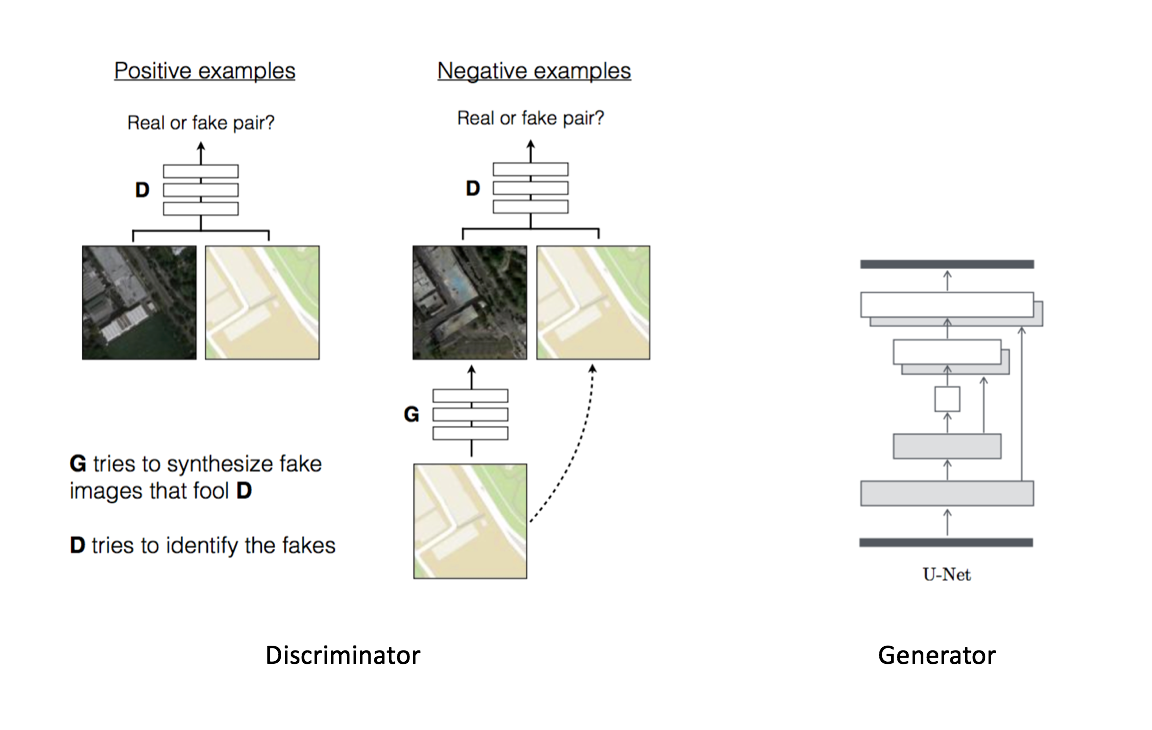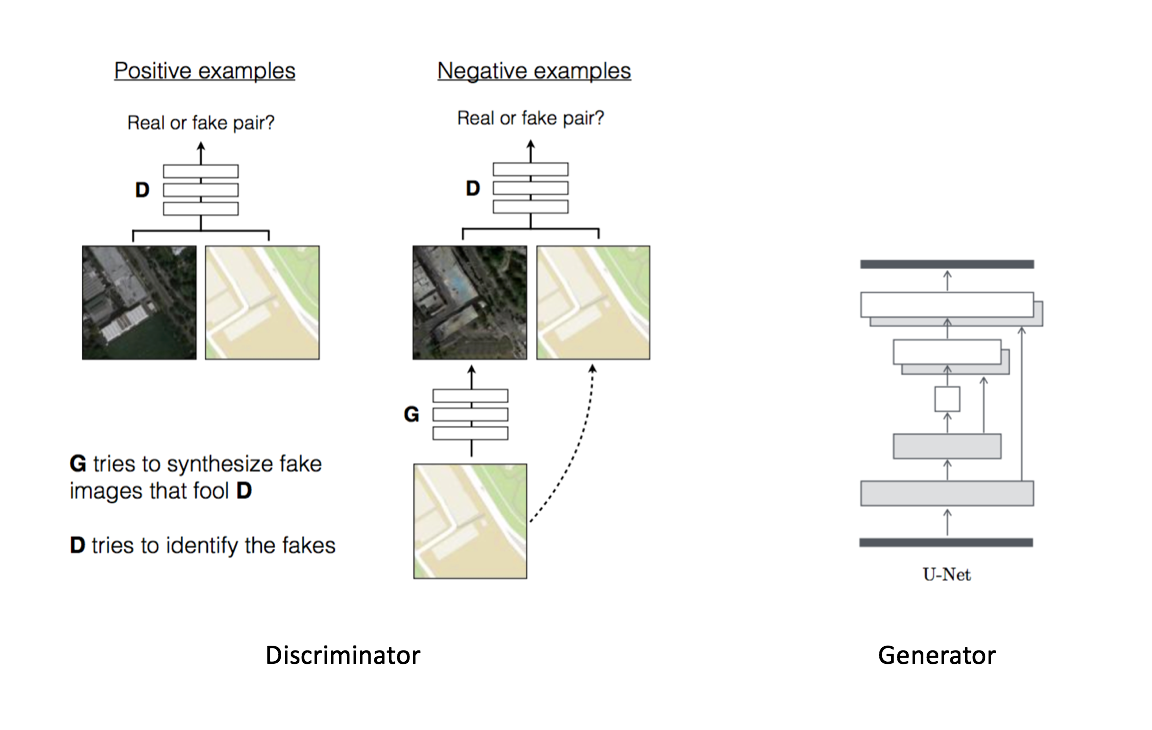

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import time
from absl import app
from absl import flags

import tensorflow as tf

FLAGS = flags.FLAGS

flags.DEFINE_integer('buffer_size', 400, 'Shuffle buffer size')
flags.DEFINE_integer('batch_size', 1, 'Batch Size')
flags.DEFINE_integer('epochs', 1, 'Number of epochs')
flags.DEFINE_string('path', None, 'Path to the data folder')
flags.DEFINE_boolean('enable_function', True, 'Enable Function?')

IMG_WIDTH = 256
IMG_HEIGHT = 256
AUTOTUNE = tf.data.experimental.AUTOTUNE


def load(image_file):
  """Loads the image and generates input and target image.

  Args:
    image_file: .jpeg file

  Returns:
    Input image, target image
  """
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image


def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image


@tf.function
def random_jitter(input_image, real_image):
  """Random jittering.

  Resizes to 286 x 286 and then randomly crops to IMG_HEIGHT x IMG_WIDTH.

  Args:
    input_image: Input Image
    real_image: Real Image

  Returns:
    Input Image, real image
  """
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image


def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image


def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image


def create_dataset(path_to_train_images, path_to_test_images, buffer_size,
                   batch_size):
  """Creates a tf.data Dataset.

  Args:
    path_to_train_images: Path to train images folder.
    path_to_test_images: Path to test images folder.
    buffer_size: Shuffle buffer size.
    batch_size: Batch size

  Returns:
    train dataset, test dataset
  """
  train_dataset = tf.data.Dataset.list_files(path_to_train_images)
  train_dataset = train_dataset.shuffle(buffer_size)
  train_dataset = train_dataset.map(
      load_image_train, num_parallel_calls=AUTOTUNE)
  train_dataset = train_dataset.batch(batch_size)

  test_dataset = tf.data.Dataset.list_files(path_to_test_images)
  test_dataset = test_dataset.map(
      load_image_test, num_parallel_calls=AUTOTUNE)
  test_dataset = test_dataset.batch(batch_size)

  return train_dataset, test_dataset


class InstanceNormalization(tf.keras.layers.Layer):
  """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""

  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset


def downsample(filters, size, norm_type='batchnorm', apply_norm=True):
  """Downsamples an input.

  Conv2D => Batchnorm => LeakyRelu

  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_norm: If True, adds the batchnorm layer

  Returns:
    Downsample Sequential Model
  """
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_norm:
    if norm_type.lower() == 'batchnorm':
      result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
      result.add(InstanceNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result


def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  """Upsamples an input.

  Conv2DTranspose => Batchnorm => Dropout => Relu

  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer

  Returns:
    Upsample Sequential Model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result


def unet_generator(output_channels, norm_type='batchnorm'):
  """Modified u-net generator model (https://arxiv.org/abs/1611.07004).

  Args:
    output_channels: Output channels
    norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.

  Returns:
    Generator model
  """


  down_stack = [
downsample(64, 4, norm_type, apply_norm=False),  # (bs, 128, 128, 64)
downsample(128, 4, norm_type),  # (bs, 64, 64, 128)
downsample(256, 4, norm_type),  # (bs, 32, 32, 256)
downsample(512, 4, norm_type),  # (bs, 16, 16, 512)
# downsample(512, 4, norm_type),  # (bs, 8, 8, 512)
]

  up_stack = [
# upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 16, 16, 1024)
upsample(256, 4, norm_type, apply_dropout=True),  # (bs, 32, 32, 512)
upsample(128, 4, norm_type, apply_dropout=True),  # (bs, 64, 64, 256)
upsample(64, 4, norm_type),  # (bs, 128, 128, 128)
]
  # down_stack = [
  #     downsample(64, 4, norm_type, apply_norm=False),  # (bs, 128, 128, 64)
  #     downsample(128, 4, norm_type),  # (bs, 64, 64, 128)
  #     downsample(256, 4, norm_type),  # (bs, 32, 32, 256)
  #     downsample(512, 4, norm_type),  # (bs, 16, 16, 512)
  #     downsample(512, 4, norm_type),  # (bs, 8, 8, 512)
  #     downsample(512, 4, norm_type),  # (bs, 4, 4, 512)
  #     downsample(512, 4, norm_type),  # (bs, 2, 2, 512)
  #     downsample(512, 4, norm_type),  # (bs, 1, 1, 512)
  # ]

  # up_stack = [
  #     upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 2, 2, 1024)
  #     upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 4, 4, 1024)
  #     upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 8, 8, 1024)
  #     upsample(512, 4, norm_type),  # (bs, 16, 16, 1024)
  #     upsample(256, 4, norm_type),  # (bs, 32, 32, 512)
  #     upsample(128, 4, norm_type),  # (bs, 64, 64, 256)
  #     upsample(64, 4, norm_type),  # (bs, 128, 128, 128)
  # ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 4, strides=2,
      padding='same', kernel_initializer=initializer,
      activation='tanh')  # (bs, 256, 256, 3)

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[None, None, 3])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


def discriminator(norm_type='batchnorm', target=True):
  """PatchGan discriminator model (https://arxiv.org/abs/1611.07004).

  Args:
    norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.
    target: Bool, indicating whether target image is an input or not.

  Returns:
    Discriminator model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
  x = inp

  if target:
    tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, norm_type, False)(x)  # (bs, 128, 128, 64)
  down2 = downsample(128, 4, norm_type)(down1)  # (bs, 64, 64, 128)
  down3 = downsample(256, 4, norm_type)(down2)  # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(
      512, 4, strides=1, kernel_initializer=initializer,
      use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

  if norm_type.lower() == 'batchnorm':
    norm1 = tf.keras.layers.BatchNormalization()(conv)
  elif norm_type.lower() == 'instancenorm':
    norm1 = InstanceNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(
      1, 4, strides=1,
      kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

  if target:
    return tf.keras.Model(inputs=[inp, tar], outputs=last)
  else:
    return tf.keras.Model(inputs=inp, outputs=last)


def get_checkpoint_prefix():
  checkpoint_dir = './training_checkpoints'
  checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')

  return checkpoint_prefix


class Pix2pix(object):
  """Pix2pix class.

  Args:
    epochs: Number of epochs.
    enable_function: If true, train step is decorated with tf.function.
    buffer_size: Shuffle buffer size..
    batch_size: Batch size.
  """

  def __init__(self, epochs, enable_function):
    self.epochs = epochs
    self.enable_function = enable_function
    self.lambda_value = 100
    self.loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    self.generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    self.discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    self.generator = unet_generator(output_channels=3)
    self.discriminator = discriminator()
    self.checkpoint = tf.train.Checkpoint(
        generator_optimizer=self.generator_optimizer,
        discriminator_optimizer=self.discriminator_optimizer,
        generator=self.generator,
        discriminator=self.discriminator)

  def discriminator_loss(self, disc_real_output, disc_generated_output):
    real_loss = self.loss_object(
        tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = self.loss_object(tf.zeros_like(
        disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

  def generator_loss(self, disc_generated_output, gen_output, target):
    gan_loss = self.loss_object(tf.ones_like(
        disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (self.lambda_value * l1_loss)
    return total_gen_loss

  def train_step(self, input_image, target_image):
    """One train step over the generator and discriminator model.

    Args:
      input_image: Input Image.
      target_image: Target image.

    Returns:
      generator loss, discriminator loss.
    """
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      gen_output = self.generator(input_image, training=True)

      disc_real_output = self.discriminator(
          [input_image, target_image], training=True)
      disc_generated_output = self.discriminator(
          [input_image, gen_output], training=True)

      gen_loss = self.generator_loss(
          disc_generated_output, gen_output, target_image)
      disc_loss = self.discriminator_loss(
          disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(
        gen_loss, self.generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(
        disc_loss, self.discriminator.trainable_variables)

    self.generator_optimizer.apply_gradients(zip(
        generator_gradients, self.generator.trainable_variables))
    self.discriminator_optimizer.apply_gradients(zip(
        discriminator_gradients, self.discriminator.trainable_variables))

    return gen_loss, disc_loss

  def train(self, dataset, checkpoint_pr):
    """Train the GAN for x number of epochs.

    Args:
      dataset: train dataset.
      checkpoint_pr: prefix in which the checkpoints are stored.

    Returns:
      Time for each epoch.
    """
    time_list = []
    if self.enable_function:
      self.train_step = tf.function(self.train_step)

    for epoch in range(self.epochs):
      start_time = time.time()
      for input_image, target_image in dataset:
        gen_loss, disc_loss = self.train_step(input_image, target_image)

      wall_time_sec = time.time() - start_time
      time_list.append(wall_time_sec)

      # saving (checkpoint) the model every 20 epochs
      if (epoch + 1) % 20 == 0:
        self.checkpoint.save(file_prefix=checkpoint_pr)

      template = 'Epoch {}, Generator loss {}, Discriminator Loss {}'
      print (template.format(epoch, gen_loss, disc_loss))

    return time_list


def run_main(argv):
  del argv
  kwargs = {'epochs': FLAGS.epochs, 'enable_function': FLAGS.enable_function,
            'path': FLAGS.path, 'buffer_size': FLAGS.buffer_size,
            'batch_size': FLAGS.batch_size}
  main(**kwargs)


def main(epochs, enable_function, path, buffer_size, batch_size):
  path_to_folder = path

  pix2pix_object = Pix2pix(epochs, enable_function)

  train_dataset, _ = create_dataset(
      os.path.join(path_to_folder, 'train/*.jpg'),
      os.path.join(path_to_folder, 'test/*.jpg'),
      buffer_size, batch_size)
  checkpoint_pr = get_checkpoint_prefix()
  print ('Training ...')
  return pix2pix_object.train(train_dataset, checkpoint_pr)


# if __name__ == '__main__':
  # app.run(run_main)

2025-06-29 08:04:55.399174: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751184295.600283      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751184295.656693      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Giới thiệu về CycleGAN: Chuyển đổi ảnh không cần cặp dữ liệu

Notebook này giới thiệu về quá trình chuyển đổi ảnh không cặp (unpaired image-to-image translation) sử dụng **Conditional GANs**, như đã được mô tả trong bài báo "Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks" (còn gọi là **CycleGAN**). Bài báo này đề xuất một phương pháp có thể nắm bắt đặc điểm của một miền ảnh và tìm ra cách chuyển đổi những đặc điểm đó sang một miền ảnh khác, **mà không cần bất kỳ ví dụ huấn luyện theo cặp nào**.

Notebook này giả định bạn đã quen thuộc với **Pix2Pix**, một mô hình mà bạn có thể tìm hiểu qua hướng dẫn [Pix2Pix tutorial](https://www.tensorflow.org/tutorials/generative/pix2pix) hoặc từ đoạn code phía trên. Mã nguồn của CycleGAN tương tự như Pix2Pix, điểm khác biệt chính là việc bổ sung một hàm lỗi (loss function) và việc sử dụng dữ liệu huấn luyện không theo cặp.

CycleGAN sử dụng một **hàm lỗi nhất quán vòng lặp (cycle consistency loss)** để cho phép huấn luyện mà không yêu cầu dữ liệu theo cặp. Nói cách khác, nó có thể chuyển đổi từ một miền này sang một miền khác mà không cần ánh xạ một-một giữa miền nguồn và miền đích.

Điều này mở ra khả năng thực hiện nhiều tác vụ thú vị như nâng cao chất lượng ảnh, tô màu ảnh, chuyển đổi phong cách, v.v. Tất cả những gì bạn cần là tập dữ liệu nguồn và tập dữ liệu đích (đơn giản chỉ là một thư mục chứa ảnh).

<!-- ![Output Image 1](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/horse2zebra_1.png?raw=1)
![Output Image 2](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/horse2zebra_2.png?raw=1) -->

## Set up the input pipeline

Cài đặt gói [tensorflow_examples](https://github.com/tensorflow/examples) cho phép nhập bộ tạo (generator) và bộ phân biệt (discriminator).

In [2]:
!pip install git+https://github.com/tensorflow/examples.git
# !pip install pytorch-fid
# !pip install visdom dominate GPUtil
!pip install icrawler

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-cpkgwo9_
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-cpkgwo9_
  Resolved https://github.com/tensorflow/examples.git to commit 3c7435733a9162481df350e57c53e58d2a705e4d
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1746868094.345130988853936603129253091149118257392589495885-py3-none-any.whl size=301646 sha256=112ee4b53cb54139344ed1c587985eda2ac3fc166c22d32791921e030daf1fb9
  Stored in directory: /tmp/pip-ephem-wheel-cache-ennv18nc/wheels/91/9b/e8/6ae2ecc930bd726c578e35b313e987a687bc5ce03c3a42c2d5
Successfully built tensorflow-examples


In [3]:
import tensorflow as tf

In [4]:
import tensorflow_datasets as tfds

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

## Quy trình đầu vào (Input Pipeline)

Hướng dẫn này đào tạo một mô hình để dịch từ hình ảnh domain A sang B.

Như đã đề cập trong [bài báo](https://arxiv.org/abs/1703.10593), hãy áp dụng kỹ thuật xáo trộn ngẫu nhiên (random jittering) và lật gương (mirroring) cho tập dữ liệu huấn luyện. Đây là một số kỹ thuật tăng cường hình ảnh giúp tránh hiện tượng quá khớp (overfitting).

Điều này tương tự với những gì đã được thực hiện trong [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#load_the_dataset):

* Trong xáo trộn ngẫu nhiên, hình ảnh được thay đổi kích thước thành `286 x 286` và sau đó được cắt ngẫu nhiên thành `256 x 256`.
* Trong lật gương ngẫu nhiên, hình ảnh được lật ngẫu nhiên theo chiều ngang, tức là từ trái sang phải.

## Tạo bộ dữ liệu đường phố khi mưa và khi không mưa

In [5]:
from icrawler.builtin import GoogleImageCrawler
import os
import shutil
import random
from PIL import Image

def create_i2i_dataset(dataset_dir, queryA, queryB, num_images=200, train_split=0.9, resize_shape=(256, 256)):
    temp_dir = os.path.join(dataset_dir, "raw")
    os.makedirs(temp_dir, exist_ok=True)

    def download_and_resize(query, subdir):
        target_dir = os.path.join(temp_dir, subdir)
        os.makedirs(target_dir, exist_ok=True)
        crawler = GoogleImageCrawler(storage={'root_dir': target_dir})
        crawler.crawl(keyword=query, max_num=num_images)

        for filename in os.listdir(target_dir):
            filepath = os.path.join(target_dir, filename)
            try:
                with Image.open(filepath) as img:
                    img = img.convert("RGB")
                    img = img.resize(resize_shape, Image.Resampling.LANCZOS)
                    img.save(filepath)
            except Exception as e:
                print(f"⚠️ Lỗi xử lý ảnh {filepath}: {e}")
                os.remove(filepath)

        return target_dir

    print(f"📥 Downloading images for: {queryA}")
    pathA = download_and_resize(queryA, "A")

    print(f"📥 Downloading images for: {queryB}")
    pathB = download_and_resize(queryB, "B")

    for folder in ['trainA', 'trainB', 'testA', 'testB']:
        os.makedirs(os.path.join(dataset_dir, folder), exist_ok=True)

    def split_and_copy(src_folder, train_folder, test_folder):
        images = [f for f in os.listdir(src_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(images)
        split_idx = int(len(images) * train_split)
        for i, img in enumerate(images):
            src = os.path.join(src_folder, img)
            dst = os.path.join(dataset_dir, train_folder if i < split_idx else test_folder, img)
            shutil.copy(src, dst)

    split_and_copy(pathA, 'trainA', 'testA')
    split_and_copy(pathB, 'trainB', 'testB')

    shutil.rmtree(temp_dir)
    print(f"✅ Dataset created at: {dataset_dir}")

create_i2i_dataset("vangogh2monet", "Rainy street", "Normal street", num_images=100)

📥 Downloading images for: Van Gogh painting
⚠️ Lỗi xử lý ảnh vangogh2monet/raw/A/000079.jpg: broken data stream when reading image file
📥 Downloading images for: Monet painting
⚠️ Lỗi xử lý ảnh vangogh2monet/raw/B/000037.jpg: broken data stream when reading image file
⚠️ Lỗi xử lý ảnh vangogh2monet/raw/B/000047.jpg: broken data stream when reading image file
✅ Dataset created at: vangogh2monet


I0000 00:00:1751184431.470022      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


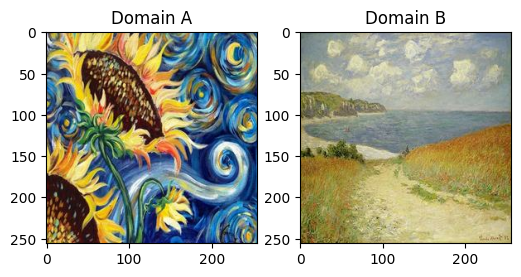

In [6]:
# dataset, metadata = tfds.load('cycle_gan/horse2zebra',
#                               with_info=True, as_supervised=True, split={
#                                   'trainA': 'trainA[:200]',
#                                   'trainB': 'trainB[:200]',
#                                   'testA': 'testA[:4]',
#                                   'testB': 'testB[:5]'
#                               })

# train_horses, train_zebras = dataset['trainA'], dataset['trainB']
# test_horses, test_zebras = dataset['testA'], dataset['testB']

import tensorflow as tf
import torch
import os

def load_custom_cycleGAN_dataset(dataset_dir, resize=(256, 256), batch_size=1):
    def load_image_from_folder(folder):
        ds = tf.data.Dataset.list_files(os.path.join(dataset_dir, folder, '*'))
        
        def decode_img(file_path):
            img = tf.io.read_file(file_path)
            img = tf.image.decode_jpeg(img, channels=3)
            # img = tf.image.convert_image_dtype(img, tf.float64)
            # img = tf.image.resize(img, resize)
            return img, tf.cast(0., tf.int64)
        
        return ds.map(decode_img, num_parallel_calls=tf.data.AUTOTUNE)

    datasets = {
        'trainA': load_image_from_folder('trainA'),
        'trainB': load_image_from_folder('trainB'),
        'testA':  load_image_from_folder('testA'),
        'testB':  load_image_from_folder('testB'),
    }

    return datasets

datasets = load_custom_cycleGAN_dataset('vangogh2monet', batch_size=1)
trainA, trainB = datasets['trainA'], datasets['trainB']
testA, testB = datasets['testA'], datasets['testB']

# Xem thử một cặp ảnh
import matplotlib.pyplot as plt

for a, b in zip(trainA.take(1), trainB.take(1)):
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.imshow(a[0])
    plt.title("Domain A")
    plt.subplot(1,2,2)
    plt.imshow(b[0])
    plt.title("Domain B")
    plt.show()

In [7]:
BUFFER_SIZE = 1000
BATCH_SIZE = 2
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [8]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [9]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [10]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [11]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [12]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [13]:
trainA = trainA.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

trainB = trainB.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

testA = testA.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

testB = testB.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [14]:
sample_A = next(iter(trainA))
sample_B = next(iter(trainB))

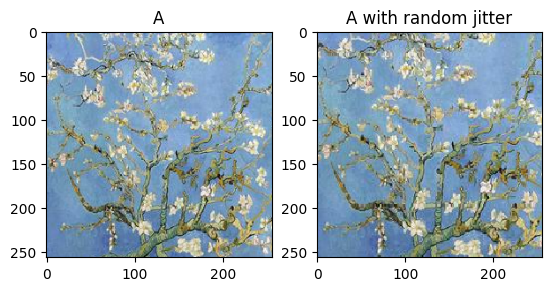

In [15]:
plt.subplot(121)
plt.title('A')
plt.imshow(sample_A[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('A with random jitter')
plt.imshow(random_jitter(sample_A[0]) * 0.5 + 0.5)

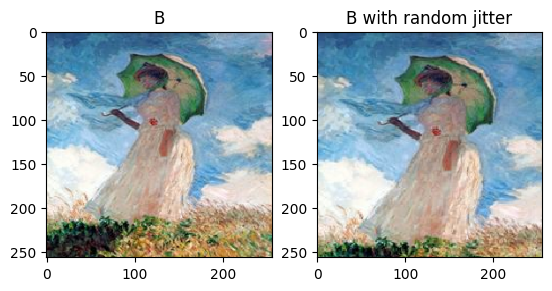

In [16]:
plt.subplot(121)
plt.title('B')
plt.imshow(sample_B[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('B with random jitter')
plt.imshow(random_jitter(sample_B[0]) * 0.5 + 0.5)

## Import and reuse the Pix2Pix models

## Mô hình CycleGAN

Nhập **bộ tạo (generator)** và **bộ phân biệt (discriminator)** đã được sử dụng trong [Pix2Pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) thông qua gói [tensorflow\_examples](https://github.com/tensorflow/examples) đã được cài đặt.

Kiến trúc mô hình được sử dụng trong hướng dẫn này rất giống với mô hình đã được dùng trong [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py). Một số khác biệt là:

  * CycleGAN sử dụng **chuẩn hóa từng phiên bản (instance normalization)** thay vì **chuẩn hóa hàng loạt (batch normalization)**.
  * [Bài báo về CycleGAN](https://arxiv.org/abs/1703.10593) sử dụng bộ tạo dựa trên `resnet` đã được sửa đổi. Hướng dẫn này đang sử dụng bộ tạo `unet` đã được sửa đổi để đơn giản hóa.

Có 2 bộ tạo (G và F) và 2 bộ phân biệt (X và Y) đang được huấn luyện ở đây:

  * **Bộ tạo `G`** học cách biến đổi hình ảnh `X` thành hình ảnh `Y`. $(G: X -\> Y)$
  * **Bộ tạo `F`** học cách biến đổi hình ảnh `Y` thành hình ảnh `X`. $(F: Y -\> X)$
  * **Bộ phân biệt `D_X`** học cách phân biệt giữa hình ảnh `X` và hình ảnh `X` được tạo ra (`F(Y)`).
  * **Bộ phân biệt `D_Y`** học cách phân biệt giữa hình ảnh `Y` và hình ảnh `Y` được tạo ra (`G(X)`).

![Cyclegan model](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cyclegan_model.png?raw=1)

In [17]:
OUTPUT_CHANNELS = 3

generator_g = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = discriminator(norm_type='instancenorm', target=False)
discriminator_y = discriminator(norm_type='instancenorm', target=False)

I0000 00:00:1751184434.544120      31 cuda_dnn.cc:529] Loaded cuDNN version 90300


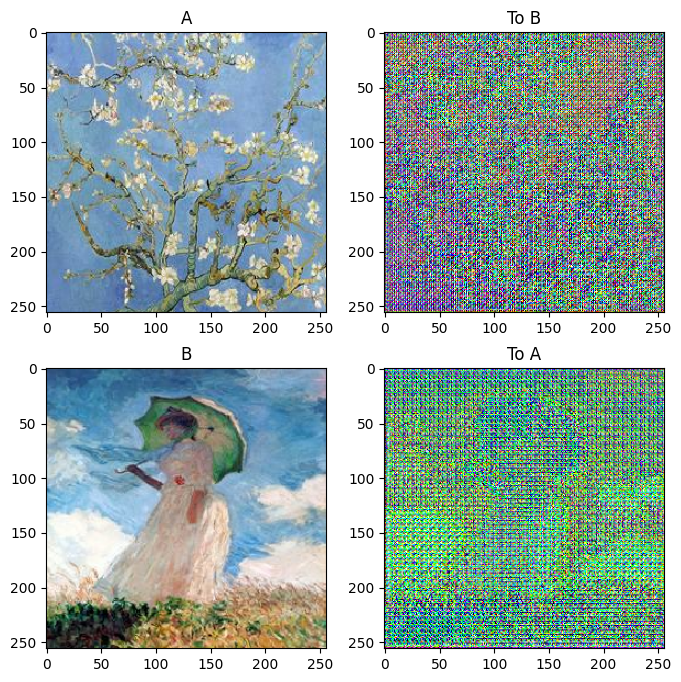

In [18]:
to_B = generator_g(sample_A)
to_A = generator_f(sample_B)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_A, to_B, sample_B, to_A]
title = ['A', 'To B', 'B', 'To A']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

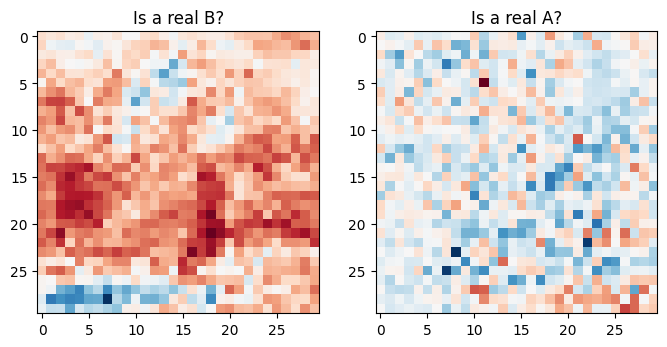

In [20]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real B?')
plt.imshow(discriminator_y(sample_B)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real A?')
plt.imshow(discriminator_x(sample_A)[0, ..., -1], cmap='RdBu_r')

plt.show()

## Loss functions

Trong CycleGAN, vì không có dữ liệu cặp để huấn luyện, nên không có gì đảm bảo rằng cặp **đầu vào `x`** và **mục tiêu `y`** có ý nghĩa trong quá trình huấn luyện. Do đó, để đảm bảo mạng học được ánh xạ chính xác, các tác giả đề xuất **hàm mất mát nhất quán chu kỳ (cycle consistency loss)**. Hàm mất mát của bộ phân biệt và hàm mất mát của bộ tạo tương tự như những gì đã được sử dụng trong [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#build_the_generator).

In [21]:
LAMBDA = 10

In [22]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [23]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [24]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

Sự **nhất quán chu kỳ (cycle consistency)** có nghĩa là kết quả phải gần giống với đầu vào ban đầu. Ví dụ, nếu dịch một câu từ tiếng Anh sang tiếng Pháp, sau đó dịch ngược lại từ tiếng Pháp sang tiếng Anh, thì câu kết quả phải giống với câu gốc.

Trong hàm mất mát nhất quán chu kỳ:

* Hình ảnh $X$ được đưa qua bộ tạo $G$ để tạo ra hình ảnh $\hat{Y}$.
* Hình ảnh được tạo $\hat{Y}$ được đưa qua bộ tạo $F$ để tạo ra hình ảnh xoay vòng $\hat{X}$.
* Sai số tuyệt đối trung bình được tính toán giữa $X$ và $\hat{X}$.

$$mất\ mát\ nhất\ quán\ chu\ kỳ\ thuận: X \rightarrow G(X) \rightarrow F(G(X)) \sim \hat{X}$$

$$mất\ mát\ nhất\ quán\ chu\ kỳ\ nghịch: Y \rightarrow F(Y) \rightarrow G(F(Y)) \sim \hat{Y}$$


![Cycle loss](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cycle_loss.png?raw=1)

In [25]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

Như đã trình bày ở trên, **bộ tạo $G$** có nhiệm vụ dịch hình ảnh $X$ sang hình ảnh $Y$. **Hàm mất mát đồng nhất (Identity loss)** cho rằng, nếu bạn đưa hình ảnh $Y$ vào bộ tạo $G$, nó phải tạo ra hình ảnh $Y$ thực hoặc một cái gì đó gần giống với hình ảnh $Y$.

Nếu bạn chạy mô hình chuyển đổi ngựa vằn thành ngựa trên một bức ảnh ngựa, hoặc mô hình chuyển đổi ngựa thành ngựa vằn trên một bức ảnh ngựa vằn, nó không nên thay đổi nhiều bức ảnh đó vì hình ảnh đã chứa lớp đích.

$$Hàm\ mất\ mát\ đồng\ nhất = |G(Y) - Y| + |F(X) - X|$$

In [26]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

Khởi tạo các **bộ tối ưu hóa (optimizers)** cho tất cả các bộ tạo (generators) và bộ phân biệt (discriminators).

In [27]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints

In [28]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

## Training

Lưu ý: Mô hình ví dụ này được huấn luyện với số **epoch** ít hơn để giữ thời gian huấn luyện hợp lý cho hướng dẫn này. Các hình ảnh được tạo ra sẽ có chất lượng thấp hơn đáng kể.

In [29]:
EPOCHS = 300

In [30]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

Mặc dù vòng lặp huấn luyện có vẻ phức tạp, nhưng nó bao gồm bốn bước cơ bản:

* Lấy các dự đoán.
* Tính toán hàm mất mát.
* Tính toán độ dốc (gradients) bằng phương pháp lan truyền ngược (backpropagation).
* Áp dụng độ dốc vào bộ tối ưu hóa (optimizer).

In [31]:
# Create a dictionary of tf.keras.metrics.Mean objects for tracking loss
LOSS_METRICS = {
    'gen_g_loss': tf.keras.metrics.Mean(name='gen_g_loss'),
    'gen_f_loss': tf.keras.metrics.Mean(name='gen_f_loss'),
    'total_cycle_loss': tf.keras.metrics.Mean(name='total_cycle_loss'),
    'total_gen_g_loss': tf.keras.metrics.Mean(name='total_gen_g_loss'),
    'total_gen_f_loss': tf.keras.metrics.Mean(name='total_gen_f_loss'),
    'disc_x_loss': tf.keras.metrics.Mean(name='disc_x_loss'),
    'disc_y_loss': tf.keras.metrics.Mean(name='disc_y_loss'),
}

@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        id_loss_g = identity_loss(real_y, same_y)
        id_loss_f = identity_loss(real_x, same_x)

        total_gen_g_loss = gen_g_loss + cycle_loss + id_loss_g
        total_gen_f_loss = gen_f_loss + cycle_loss + id_loss_f

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Compute gradients
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    # Apply gradients
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

    # Update loss metrics
    LOSS_METRICS['gen_g_loss'].update_state(gen_g_loss)
    LOSS_METRICS['gen_f_loss'].update_state(gen_f_loss)
    LOSS_METRICS['total_cycle_loss'].update_state(cycle_loss)
    LOSS_METRICS['total_gen_g_loss'].update_state(total_gen_g_loss)
    LOSS_METRICS['total_gen_f_loss'].update_state(total_gen_f_loss)
    LOSS_METRICS['disc_x_loss'].update_state(disc_x_loss)
    LOSS_METRICS['disc_y_loss'].update_state(disc_y_loss)

    return {
    'gen_g_loss': gen_g_loss,
    'gen_f_loss': gen_f_loss,
    'total_cycle_loss': cycle_loss,
    'total_gen_g_loss': total_gen_g_loss,
    'total_gen_f_loss': total_gen_f_loss,
    'disc_x_loss': disc_x_loss,
    'disc_y_loss': disc_y_loss
}


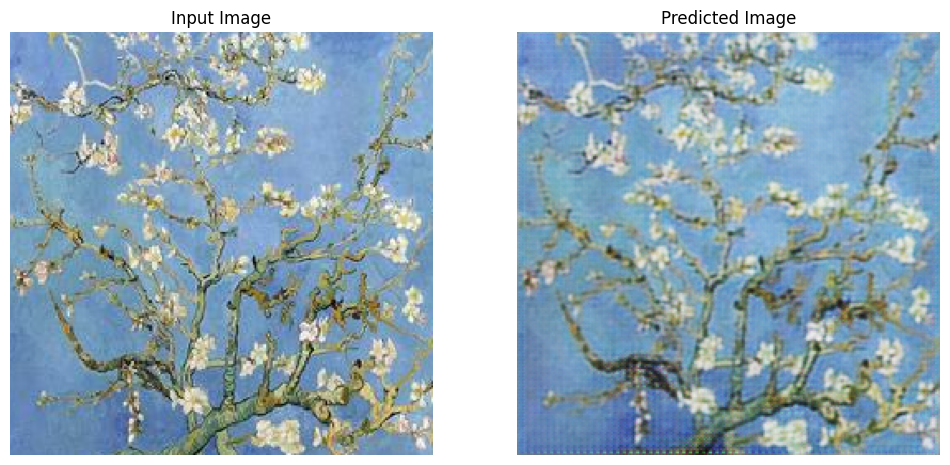

Time taken for epoch 17 is 5.575470924377441 sec

..

In [ ]:
import json
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os

step_losses = []  # collect all step losses

for epoch in range(EPOCHS):
    start = time.time()
    n = 0

    for image_x, image_y in tf.data.Dataset.zip((trainA, trainB)):
        loss_dict = train_step(image_x, image_y)
        step_losses.append({k: float(v.numpy()) for k, v in loss_dict.items()})  # convert to JSON-safe

        if n % 10 == 0:
            print('.', end='')
        n += 1

    clear_output(wait=True)
    generate_images(generator_g, sample_A)

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

    print('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

with open('step_losses.json', 'w') as f:
    json.dump(step_losses, f, indent=2)

import matplotlib.pyplot as plt

# Load step losses if needed (optional)
# with open('step_losses.json', 'r') as f:
#     step_losses = json.load(f)

loss_names = step_losses[0].keys()
steps = list(range(len(step_losses)))

plt.figure(figsize=(12, 8))
for loss_name in loss_names:
    plt.plot(steps, [loss[loss_name] for loss in step_losses], label=loss_name)

plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('CycleGAN Training Losses Over Time')
plt.legend()
plt.grid(True)

plt.savefig('training_losses.png')  # Save the figure
plt.show()


## Generate using test dataset

In [ ]:
# Run the trained model on the test dataset
for inp in testA.take(5):
  generate_images(generator_g, inp)